In [ ]:
#| default_exp correlation_utilities

# Correlation Utilities for Replicated Samples

> Overview

This notebook contains utility functions and workflows for analyzing correlations between replicated samples in experimental data. 

In [ ]:
#| hide
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional, Union, Tuple
from dataclasses import dataclass


In [ ]:
class ReplicateAnalyzer:
    """
    A class for analyzing and visualizing correlations between replicated samples.
    
    This class provides utilities for assessing reproducibility and reliability
    in experimental measurements, with a focus on correlation metrics and
    visualization tools.
    """
    
    def __init__(self, 
                 data: Optional[pd.DataFrame] = None,
                 sample_groups: Optional[List[str]] = None):
        """
        Initialize the ReplicateAnalyzer with optional data and sample groupings.
        
        Parameters
        ----------
        data : pd.DataFrame, optional
            Dataframe containing the measurement data for replicates
        sample_groups : List[str], optional
            List of sample group identifiers mapping each column in the dataframe
            to its corresponding sample group
        """
        self.data = data
        self.sample_groups = sample_groups
        self.results = {}  # Store analysis results
        
    def set_data(self, 
                data: pd.DataFrame, 
                sample_groups: List[str]):
        """
        Set or update the data and sample groupings.
        
        Parameters
        ----------
        data : pd.DataFrame
            Dataframe containing the measurement data for replicates
        sample_groups : List[str]
            List of sample group identifiers mapping each column in the dataframe
            to its corresponding sample group
        """
        self.data = data
        self.sample_groups = sample_groups
        
    def _validate_inputs(self) -> bool:
        """
        Validate that the data and sample groups are properly set and compatible.
        
        Returns
        -------
        bool
            True if inputs are valid, raises ValueError otherwise
        """
        if self.data is None:
            raise ValueError("Data has not been set. Use set_data() method first.")
            
        if self.sample_groups is None:
            raise ValueError("Sample groups have not been set. Use set_data() method first.")
            
        if len(self.sample_groups) != self.data.shape[1]:
            raise ValueError(f"Number of sample groups ({len(self.sample_groups)}) "
                           f"does not match number of data columns ({self.data.shape[1]})")
            
        return True
    
    def calculate_coefficient_of_variation(self) -> Dict[str, float]:
        """
        Calculate coefficient of variation (CV) for each sample group.
        
        The coefficient of variation is defined as the ratio of the standard deviation
        to the mean, and is a standardized measure of dispersion.
        
        Returns
        -------
        Dict[str, float]
            Dictionary mapping each sample group to its CV value
        """
        self._validate_inputs()
        
        # Get unique sample groups
        unique_groups = list(set(self.sample_groups))
        
        # Calculate CV for each group
        cv_results = {}
        
        for group in unique_groups:
            # Get column indices for this group
            group_indices = [i for i, g in enumerate(self.sample_groups) if g == group]
            
            # Extract the data for this group
            group_data = self.data.iloc[:, group_indices]
            
            # Calculate mean and std along the columns (axis=1 is for rows)
            means = group_data.mean(axis=1)
            stds = group_data.std(axis=1, ddof=1)  # ddof=1 for sample standard deviation
            
            # Calculate CV (std/mean) and average across all measurements
            # Avoid division by zero by replacing zeros with NaN
            with np.errstate(divide='ignore', invalid='ignore'):
                cv_values = stds / means
            
            # Store the mean CV for this group (ignoring NaN values)
            cv_results[group] = np.nanmean(cv_values) * 100  # Convert to percentage
        
        # Store results for later use
        self.results['cv'] = cv_results
        
        return cv_results
    
    def plot_coefficient_of_variation(self, 
                                     figsize: Tuple[int, int] = (10, 6),
                                     title: str = "Coefficient of Variation Across Sample Groups",
                                     ylabel: str = "Coefficient of Variation (%)",
                                     color: str = "skyblue",
                                     sort_values: bool = True,
                                     save_path: Optional[str] = None) -> plt.Figure:
        """
        Visualize the coefficient of variation for each sample group as a bar plot.
        
        Parameters
        ----------
        figsize : Tuple[int, int], optional
            Size of the figure (width, height) in inches
        title : str, optional
            Title of the plot
        ylabel : str, optional
            Label for the y-axis
        color : str, optional
            Color for the bars
        sort_values : bool, optional
            Whether to sort the bars by CV value (descending)
        save_path : str, optional
            Path to save the figure
            
        Returns
        -------
        plt.Figure
            The matplotlib figure object
        """
        # Calculate CV if not already done
        if 'cv' not in self.results:
            self.calculate_coefficient_of_variation()
            
        cv_data = self.results['cv']
        
        # Convert to DataFrame for easier plotting
        cv_df = pd.DataFrame({
            'Sample Group': list(cv_data.keys()),
            'CV (%)': list(cv_data.values())
        })
        
        # Sort by CV value if requested
        if sort_values:
            cv_df = cv_df.sort_values('CV (%)', ascending=False)
        
        # Create the plot
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot the bars
        sns.barplot(x='Sample Group', y='CV (%)', data=cv_df, color=color, ax=ax)
        
        # Customize the plot
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Sample Group', fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        
        # Rotate x-axis labels if there are many groups
        if len(cv_data) > 5:
            plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        
        # Save if a path is provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        return fig
    
    def get_sample_group_mapping(self) -> Dict[str, List[str]]:
        """
        Get a mapping of sample groups to their corresponding column names.
        
        Returns
        -------
        Dict[str, List[str]]
            Dictionary mapping each sample group to a list of column names
        """
        self._validate_inputs()
        
        mapping = {}
        for group, col_name in zip(self.sample_groups, self.data.columns):
            if group not in mapping:
                mapping[group] = []
            mapping[group].append(col_name)
            
        return mapping
    
    def calculate_cv_distribution(self, exclude_zeros: bool = True) -> pd.DataFrame:
        """
        Calculate the coefficient of variation for all measurements within each sample group.
        
        This method calculates individual CV values for each measurement (row) in the dataset,
        grouped by sample group, providing a distribution of CV values rather than an average.
        
        Parameters
        ----------
        exclude_zeros : bool, optional (default=True)
            Whether to exclude rows with zeros when calculating CV, as zeros can 
            artificially inflate CV values or cause division by zero errors.
            
        Returns
        -------
        pd.DataFrame
            DataFrame containing CV values for each measurement in each sample group.
            Each column represents a sample group, each row represents a measurement.
        """
        self._validate_inputs()
        
        # Get the mapping of groups to columns
        group_mapping = self.get_sample_group_mapping()
        
        # Calculate CV for each group
        cv_distributions = {}
        
        for group, columns in group_mapping.items():
            # Extract the data for this group
            group_data = self.data[columns]
            
            if exclude_zeros:
                # Create a mask that identifies rows with any zeros
                zero_mask = (group_data == 0).any(axis=1)
                # Filter out rows with zeros
                filtered_data = group_data[~zero_mask]
            else:
                filtered_data = group_data
                
            # Calculate mean and std along the columns
            means = filtered_data.mean(axis=1)
            stds = filtered_data.std(axis=1, ddof=1)  # ddof=1 for sample standard deviation
            
            # Calculate CV (std/mean) * 100 to get percentage
            with np.errstate(divide='ignore', invalid='ignore'):
                cv_values = (stds / means) * 100
            
            # Replace inf and -inf with NaN
            cv_values.replace([np.inf, -np.inf], np.nan, inplace=True)
            
            # Store CV values for this group
            cv_distributions[group] = cv_values
        
        # Create a DataFrame with all CV distributions
        cv_df = pd.DataFrame(cv_distributions)
        
        # Store results for later use
        self.results['cv_distribution'] = cv_df
        
        return cv_df
    
    def plot_cv_boxplot(self, 
                        min_y: float = -0.1, 
                        max_y: float = 50,
                        figsize: Tuple[int, int] = (12, 7),
                        color_palette: str = "viridis",
                        exclude_zeros: bool = True,
                        display_median: bool = True,
                        title: str = "Coefficient of Variation (CV) Distribution by Sample Group",
                        reference_line: Optional[float] = 20,
                        save_path: Optional[str] = None) -> plt.Figure:
        """
        Creates a boxplot of the coefficient of variation (CV) distribution for each sample group.
        
        This method visualizes the distribution of CV values across all measurements for each
        sample group, providing insight into the spread and variability of replicates.
        
        Parameters
        ----------
        min_y : float, optional (default=-0.1)
            Minimum value for y-axis in the plot.
        
        max_y : float, optional (default=50)
            Maximum value for y-axis in the plot.
            
        figsize : Tuple[int, int], optional (default=(12, 7))
            Size of the figure as (width, height) in inches.
            
        color_palette : str, optional (default="viridis")
            Name of the seaborn color palette to use for the boxplots.
            
        exclude_zeros : bool, optional (default=True)
            Whether to exclude rows with zeros when calculating CV.
            
        display_median : bool, optional (default=True)
            Whether to display the median CV value on each boxplot.
            
        title : str, optional (default="Coefficient of Variation (CV) Distribution by Sample Group")
            Title for the plot.
            
        reference_line : float, optional (default=20)
            Value at which to draw a reference line. Common thresholds in proteomics
            are 20% for technical replicates. Set to None to disable.
            
        save_path : str, optional (default=None)
            Path to save the figure. If None, figure is not saved.
            
        Returns
        -------
        plt.Figure
            The matplotlib figure object containing the boxplot visualization.
            
        Notes
        ------
        - For proteomics data, typically CVs below 20% indicate good reproducibility for technical replicates
        - CVs below 30% might be acceptable for biological replicates
        """
        # Calculate CV distributions if not already done
        if 'cv_distribution' not in self.results:
            self.calculate_cv_distribution(exclude_zeros=exclude_zeros)
            
        cv_df = self.results['cv_distribution']
        
        # Set up a more attractive plot style
        sns.set_style("whitegrid")
        colors = sns.color_palette(color_palette, n_colors=len(cv_df.columns))
        
        # Create the figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Create boxplot with seaborn for better aesthetics
        boxplot = sns.boxplot(data=cv_df, palette=colors, showfliers=False, ax=ax)
        
        # Display median values on the boxplots if requested
        if display_median:
            for i, col in enumerate(cv_df.columns):
                median_val = cv_df[col].median()
                ax.text(
                    i, median_val + 0.5, 
                    f'{median_val:.2f}%', 
                    horizontalalignment='center',
                    color='darkblue', 
                    weight='bold'
                )
        
        # Add title and labels
        ax.set_title(title, fontsize=14)
        ax.set_ylabel('CV (%)', fontsize=12)
        ax.set_xlabel('Sample Groups', fontsize=12)
        
        # Set y-axis limits
        ax.set_ylim(min_y, max_y)
        
        # Add a horizontal reference line if specified
        if reference_line is not None:
            ax.axhline(y=reference_line, color='red', linestyle='--', alpha=0.5)
            ax.text(len(cv_df.columns)-1, reference_line + 1, f'{reference_line}% CV', 
                   color='red', ha='right')
        
        # Rotate x labels if there are many groups
        if len(cv_df.columns) > 5:
            plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        
        # Save if a path is provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            
        return fig

## Test Calss

Mean Coefficient of Variation Results:
{'mysample_1': 17.080592807021713, 'mysample_2': 31.238071697274144, 'mysample_3': 59.19997632844498}

Generating mean CV bar plot...

Sample Group Mapping:
mysample_1: ['S1-Replica1', 'S1-Replica2', 'S1-Replica3']
mysample_2: ['S2-Replica1', 'S2-Replica2', 'S2-Replica3']
mysample_3: ['S3-Replica1', 'S3-Replica2']

Calculating CV distribution...

CV Distribution Summary Statistics:
       mysample_1  mysample_2  mysample_3
count  100.000000  100.000000  100.000000
mean    17.080593   31.238072   59.199976
std      9.291617   17.255365   34.850935
min      1.571174    4.294527    0.111769
25%     10.560251   16.585752   30.218940
50%     15.791861   29.000638   52.498173
75%     21.370398   39.970172   92.043385
max     49.541067   72.443491  125.483679

Generating CV distribution boxplot...


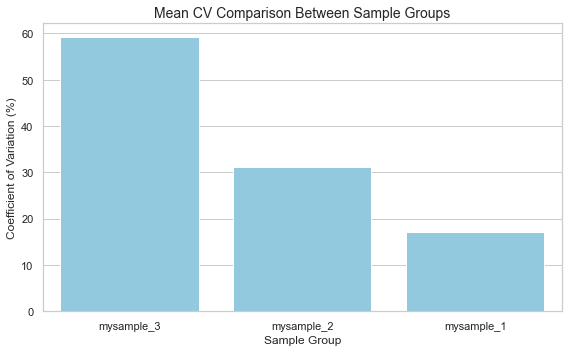

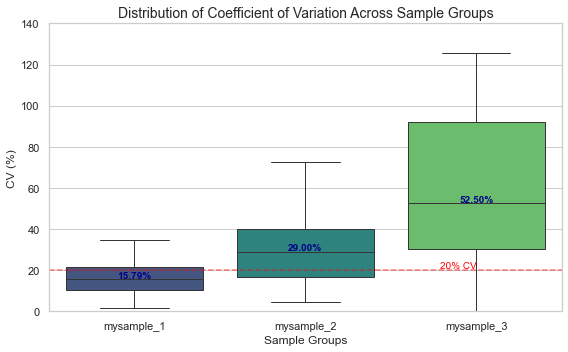

In [ ]:

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Example data creation
np.random.seed(42)  # For reproducibility

# Create a sample dataframe with replicated measurements
# Let's say we have 100 genes measured across 2 sample groups with 3 replicates each
n_genes = 100

# Sample 1 replicates with moderate variability
s1_rep1 = np.random.lognormal(mean=2, sigma=0.2, size=n_genes)
s1_rep2 = np.random.lognormal(mean=2, sigma=0.2, size=n_genes)
s1_rep3 = np.random.lognormal(mean=2, sigma=0.2, size=n_genes)

# Sample 2 replicates with higher variability
s2_rep1 = np.random.lognormal(mean=1.5, sigma=0.4, size=n_genes)
s2_rep2 = np.random.lognormal(mean=1.5, sigma=0.4, size=n_genes)
s2_rep3 = np.random.lognormal(mean=1.5, sigma=0.4, size=n_genes)

# Create a third sample group with very high variability (for demonstration)
s3_rep1 = np.random.lognormal(mean=2, sigma=0.8, size=n_genes)
s3_rep2 = np.random.lognormal(mean=2, sigma=0.8, size=n_genes)

# Create dataframe
data = pd.DataFrame({
    'S1-Replica1': s1_rep1,
    'S1-Replica2': s1_rep2,
    'S1-Replica3': s1_rep3,
    'S2-Replica1': s2_rep1,
    'S2-Replica2': s2_rep2,
    'S2-Replica3': s2_rep3,
    'S3-Replica1': s3_rep1,
    'S3-Replica2': s3_rep2
})

# Define sample groups
sample_groups = ['mysample_1', 'mysample_1', 'mysample_1', 
                'mysample_2', 'mysample_2', 'mysample_2',
                'mysample_3', 'mysample_3']

# Initialize analyzer with data
analyzer = ReplicateAnalyzer(data, sample_groups)

# Calculate coefficient of variation (average across all measurements)
cv_results = analyzer.calculate_coefficient_of_variation()
print("Mean Coefficient of Variation Results:")
print(cv_results)

# Visualize the mean CV results as a bar plot
print("\nGenerating mean CV bar plot...")
fig1 = analyzer.plot_coefficient_of_variation(
    title="Mean CV Comparison Between Sample Groups",
    figsize=(8, 5)
)

# Get mapping of sample groups to column names
mapping = analyzer.get_sample_group_mapping()
print("\nSample Group Mapping:")
for group, columns in mapping.items():
    print(f"{group}: {columns}")

# Now use the new CV boxplot functionality to show the distribution of CV values
print("\nCalculating CV distribution...")
cv_distribution = analyzer.calculate_cv_distribution(exclude_zeros=True)

# Display summary statistics of the CV distribution
print("\nCV Distribution Summary Statistics:")
print(cv_distribution.describe())

# Create the CV boxplot
print("\nGenerating CV distribution boxplot...")
fig2 = analyzer.plot_cv_boxplot(
    min_y=0,  # Minimum y-axis value
    max_y=140,  # Maximum y-axis value
    figsize=(8, 5),
    color_palette="viridis",
    display_median=True,
    reference_line=20,  
    title="Distribution of Coefficient of Variation Across Sample Groups"
)

# Show plots
plt.tight_layout()
plt.show()

In [ ]:
#| export
def concordance_correlation_coefficient(y_true, y_pred):
    """
    Calculate the concordance correlation coefficient (CCC).
    
    The concordance correlation coefficient measures the agreement between two variables,
    ranging from -1 to 1, where 1 represents perfect agreement.
    
    Parameters
    ----------
    y_true : array-like
        Ground truth values.
    y_pred : array-like
        Predicted values.
        
    Returns
    -------
    float
        Concordance correlation coefficient value between -1 and 1.
        A value of 1 indicates perfect agreement between the true and predicted values.
    
    References
    ----------
    Lawrence, I., and Kuei Lin. "A concordance correlation coefficient to evaluate 
    reproducibility." Biometrics (1989): 255-268.
    """
    # Convert inputs to numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    # Calculate means
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    
    # Calculate variances and standard deviations
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    
    # Calculate Pearson correlation coefficient
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    
    # Calculate CCC
    numerator = 2 * correlation * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    
    return numerator / denominator

In [ ]:
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
concordance_correlation_coefficient(y_true, y_pred)
#0.9767891682785301

0.9767891682785301

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()